# Macaque Cortical Timescale: Single Unit vs. ECoG
In this notebook, we compare population timescale in macaques cortex measured through single unit recordings and ECoG.

Single-unit population timescales are taken from values published in [Murray et al., 2014 Nature Neuroscience](https://www.nature.com/articles/nn.3862).

ECoG data is taken from the [NeuroTycho repository](http://neurotycho.org/anesthesia-and-sleep-task). The period analyzed are the eyes open and eyes closed resting periods from the "anesthesia & sleep task", to match the single-unit experimental conditions. 2 monkeys with 4 recording sessions each, within which there are eyes open and eyes closed conditions. 

![](../data/img/chibi_murray_small.png)

The above figure (left) shows the sampled areas from Murray 2014 (colored) and the measured single unit time constants (right), overlaid on top of the ECoG grid map from one of the macaques in Neurotycho.

In this notebook, we compare single unit population time constants to time constants computed from ECoG PSD in the corresponding areas (see simulation for method explanation). ECoG electrodes are selected visually based on the above overlapping cortical map and landmark sulci/gyri on the cortex, and averaged across electrodes whenever possible.

---
### TL;DR:

We find a very strong correlation between single unit population timescales and ECoG (synaptic fluctuation) timescales, with a scaling factor of ~10x (synaptic is 10x faster than spiking population). The correlation and scaling factor is robust across monkeys and sessions, keeping in mind that the spiking and ECoG datasets come from completely different monkeys from across the world, collected from experiments 5-10 years apart.

In [5]:
%matplotlib inline

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns

sys.path.append('../')
import echo_utils

# font = {'family' : 'Arial',
#         'weight' : 'regular',
#         'size'   : 14}

font = {'family' : 'Arial',
        'weight' : 'regular',
        'size'   : 14}

import matplotlib
matplotlib.rc('font', **font)
C_ORD = plt.rcParams['axes.prop_cycle'].by_key()['color']

save_plot = True
fig_path = '../figures/neurotycho/%s.pdf'

### Get spiking population time constants & ECoG results

In [6]:
# get mean population time constants, values grabbed from Murray et al., 2014
cell_ts = {'MT':[77.,64.], 'LIP':[138., 91.], 'LPFC':[184.,180.,195.,162.], 'OFC':[176.,188.], 'ACC':[313.,340.,257.], 'S1':[65.], 'S2':[149.]}
cell_ts_avg = {k: np.array([np.mean(np.array(v)/1e3), stats.sem(np.array(v)/1e3)*2]) for k,v in cell_ts.items()}

# electrode indices for each of the corresponding areas in each monkey
loc_inds_chibi = {'MT':[3,4,109], 'LIP':[10,11], 'LPFC':[14,15,25,26], 'OFC':[23,34,45], 'ACC':[52,57,58,59], 'S1':[9,19], 'S2':[95,108]}
loc_inds_george = {'MT':[4,13,22], 'LIP':[10,11,20,21], 'LPFC':[15,24,25,26], 'OFC':[45,66], 'ACC':[52,57,58,59], 'S1':[18,19,30], 'S2':[1,2,9,108]}
loc_inds = {'Chibi': loc_inds_chibi, 'George': loc_inds_george}

area_ord = [3,1,2,0,4,6,5] # color order to match Murray figure

# load ecog results dataframe
df_combined = pd.read_csv('../data/df_macaque.csv', index_col=0)

### Correlation with monkey spiking dataset

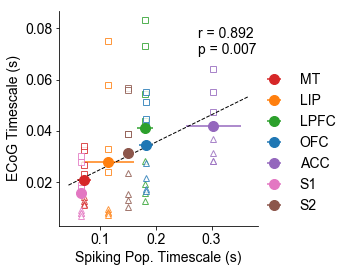

In [9]:
# define querying condition
feature = 'tau'
cond_query = 'EyesOpen'
df_cond = df_combined[df_combined['cond']==cond_query] 

# plot
plt.figure(figsize=(5,4))
ecog_ts_avg = {}

# plot per session average across electrodes
for i, k in enumerate(cell_ts.keys()):
    sesh_mkrs = [] # hack to save the session marker for next plot
    ecog_ts_avg[k] = []
    for s in df_cond['session_id'].unique():
        df_sesh = df_cond[df_cond['session_id']==s]
        patient = df_sesh['patient'].iloc[0]

        # loc_inds has the ecog electrode indices that fall into each area
        region_inds = loc_inds[patient][k] 
        marker = 's' if patient == 'George' else '^'
        sesh_mkrs.append(marker)
        ecog_ts_sess_avg = df_sesh.loc[df_sesh['chan'].isin(region_inds)].mean()[feature]
        ecog_ts_avg[k].append(ecog_ts_sess_avg)
        plt.plot(cell_ts_avg[k][0], ecog_ts_sess_avg, marker,color=C_ORD[area_ord[i]], ms=6, mfc='w', alpha=0.8)

# plot grand average
for i,k in enumerate(cell_ts.keys()):
    plt.errorbar(cell_ts_avg[k][0], np.mean(ecog_ts_avg[k]), xerr=cell_ts_avg[k][1], fmt='o', color=C_ORD[area_ord[i]], ms=10, label=k)

# fit & plot line
ts_mat = np.array([(cell_ts_avg[k][0], np.mean(ecog_ts_avg[k])) for k in cell_ts.keys()])
m,b,r,pv,stderr = stats.linregress(ts_mat)
XL = np.array(plt.xlim())
plt.plot(XL,XL*m+b, 'k--', lw=1)
s = echo_utils.sig_str(r,pv, form='text', corr_letter='r')
plt.annotate(s, xy=(0.7, 0.8), xycoords='axes fraction')

plt.legend(loc='lower left', bbox_to_anchor= (0.95, 0), ncol=1, frameon=False)
plt.xlabel('Spiking Pop. Timescale (s)');plt.ylabel('ECoG Timescale (s)'); #plt.title(cond_query)
sns.despine(); plt.tight_layout()
if save_plot: plt.savefig(fig_path%('NT_spikeECoG_'+cond_query), bbox_inches='tight')

# Single Unit Timescale Correlates Strongly with ECoG Timescale
Across sessions, we find that single unit timescale correlates strongly with ECoG timescale (correlation effect size and p-value from linear regression model, using grand mean of both spiking and ECoG data as independent and dependent variables, respectively). Grand mean of ECoG time constants also follow hierarchical organization of cortex. Note that there was no OFC ECoG coverage in either monkeys, so the closest electrodes were taken, around the frontal pole. Also note that individual sessions (hollow markers) are quite variable, and there are consistent differences between monkeys (square vs. triangle).

### Fitting linear model to individual sessions

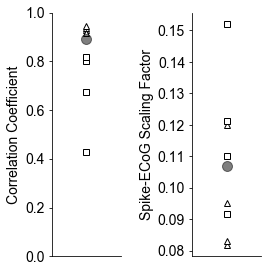

In [8]:
ecog_ts_mat = np.array([ecog_ts_avg[k] for k in cell_ts.keys()])
cell_ts_mat = np.array([cell_ts_avg[k][0] for k in cell_ts.keys()])
session_stats = np.array([stats.linregress(cell_ts_mat, ecog_ts_mat[:,i]) for i in range(ecog_ts_mat.shape[1])])

plt.figure(figsize=(4,4))
plt.subplot(1,2,1)
for s_i, s in enumerate(sesh_mkrs): plt.plot(0, session_stats[s_i,2],mec='k', mfc='w', ms=6, marker=s)
plt.plot(0, r,'ko', ms=10, alpha=0.5)
plt.ylim([0,1])
sns.despine(); plt.xticks([]); plt.ylabel('Correlation Coefficient')

plt.subplot(1,2,2)
for s_i, s in enumerate(sesh_mkrs): plt.plot(0, session_stats[s_i,0], mec='k', mfc='w', ms=6, marker=s)
plt.plot(0, m,'ko', ms=10, alpha=0.5)
sns.despine(); plt.xticks([]); plt.ylabel('Spike-ECoG Scaling Factor')

#lg = plt.legend(['Subj. C','Subj. G'], bbox_to_anchor= (1, 0.6), fancybox=False)
#for l in lg.legendHandles: l.set_linewidth(0)
plt.tight_layout(); 
if save_plot: plt.savefig(fig_path%('NT_ECoGSpikeScaling_'+cond_query), bbox_inches='tight')

# Correlation Across Sessions is Consistent
While variable across sessions and monkeys (Subj. C and G), correlation coefficients are consistently high, especially for Subj. C. The two timescales don't match one-to-one, however. There is a consistent scaling factor of about 10 (i.e., $\tau_{Spiking}$ = 10\*$\tau_{ECoG}$ ), suggesting two separate but dependent processes. Perhaps LFP timescale measures something more closely resembling membrane potential time constant, which through its integration time constant gives rise to the spiking output timescale.

### Plot tau along anterior-posterior axis

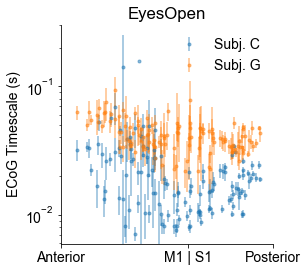

In [16]:
feature = 'tau'
plt.figure(figsize=(4.5,4))
# group by subject at the highest level, then channel, then perform average (over sessions)
grand_agg = df_cond.groupby(['patient', 'chan'])[df_combined.columns[3:]].agg([np.nanmean, stats.sem])
for g_i, g in grand_agg.groupby('patient'):
    plt.errorbar(g['y']['nanmean'], g[feature]['nanmean'], yerr=g[feature]['sem']*2., fmt='.', alpha=0.5)
    # normalize per subject
    #plt.errorbar(g['y']['nanmean'], g[feature]['nanmean']/g[feature]['nanmean'].min(), yerr=g[feature]['sem']*2., fmt='.')
    
plt.yscale('log'); plt.legend(['Subj. C', 'Subj. G'], frameon=False); 
sns.despine()
plt.xticks([0,600,1000],['Anterior','M1 | S1','Posterior'])
plt.ylabel('ECoG Timescale (s)'); plt.title(cond_query)
plt.tight_layout()
if save_plot: plt.savefig(fig_path%('NT_TauAcrossAP_'+cond_query))

# Timescale Increases from S/M Area towards Frontal and Occiptal poles
Having confirmed a correspondence between spiking and ECoG timescales, we can take advantage of the full cortex coverage of the ECoG data to measure timescale across the entire brain. Sensorimotor regions (near central sulcus) have the shortest timescale, while frontal regions by far have the longest timescale. Visual cortex, surprisingly, does not have the shortest timescale. Also note the offset between the two monkeys while preserving the spatial relationship.

### Comparing eyes open vs. eyes closed

/Users/rdgao/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


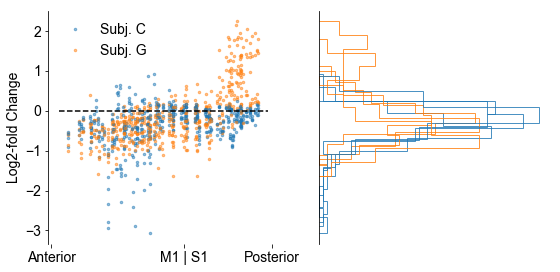

In [17]:
feature = 'tau'
conds_comp = ['EyesOpen','EyesClosed']
plt.figure(figsize=(8,4))
for s in df_combined['session_id'].unique():
    df_comp = [df_combined[np.logical_and(df_combined['cond']==c, df_combined['session_id']==s)] for c in conds_comp]

    # check that the subsampled rows are properly aligned in space and session
    #print(np.logical_and(df_comp[1]['y']==df_comp[1]['y'],df_comp[1]['session_id']==df_comp[1]['session_id']).all())
    cond_ratio = np.log2(df_comp[1][feature].values/df_comp[0][feature].values)
    C = C_ORD[0 if df_comp[0].iloc[0]['patient']=='Chibi' else 1]

    # plot along A-P axis
    plt.subplot(1,2,1)
    plt.plot(df_comp[1]['y'], cond_ratio, '.', color=C, alpha=0.5, ms=5)
    
    # plot histogram
    plt.subplot(1,2,2)
    plt.hist(cond_ratio[~np.isnan(cond_ratio)], 10, histtype='step', color=C, orientation='horizontal', alpha=0.8)

plt.subplot(1,2,1)
plt.plot(plt.xlim(),[0,0],'k--')
plt.legend(['Subj. C', 'Subj. G'], frameon=False); 
plt.xticks([0,600,1000],['Anterior','M1 | S1','Posterior'])
plt.ylabel('Log2-fold Change'); sns.despine()

plt.subplot(1,2,2)
plt.xticks([]); plt.yticks([])
sns.despine(bottom=True); plt.tight_layout()
if save_plot: plt.savefig(fig_path%('NT_EO2EC'), bbox_inches='tight')

### Plot tau-exp correlation

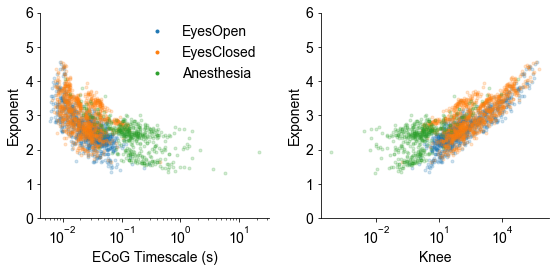

In [19]:
plt.figure(figsize=(8,4))
for cond in df_combined['cond'].unique()[[0,1,3]]:
    df_plot = df_combined[df_combined['cond']==cond]
    plt.subplot(1,2,1)
    plt.semilogx(df_plot['tau'],df_plot['exp'],'.', alpha=0.2, label=cond)
    plt.xlabel('ECoG Timescale (s)'); plt.ylabel('Exponent'); plt.ylim([0, 6]); sns.despine()
    # knee-exp
    plt.subplot(1,2,2)
    plt.semilogx(df_plot['knee'],df_plot['exp'],'.', alpha=0.2, label=cond)
    plt.xlabel('Knee'); plt.ylabel('Exponent'); plt.ylim([0, 6]); sns.despine()

plt.subplot(1,2,1); 
lg=plt.legend(fancybox=False, frameon=False)
for l in lg.legendHandles: l._legmarker.set_alpha(1)
plt.tight_layout()
if save_plot: plt.savefig(fig_path%'NT_tau_exp')

# Timescale vs. Scale-free Processes
In all the conditions, PSD exponent (scale-free) and time constant (characteristic timescale) are very correlated. Note that FOOOF estimates PSD exponent for the portion past the knee, and thus should be independent of the change in timescale. 

If there are two separate processes, then they are very related to each other. Or perhaps we are characterizing a single process in two different ways. Importantly, this is not an artifact of the timescale computation, as that would induce the opposite correlation (see human ECoG notebook MNI_rest.ipynb for simulation).

# Macaque ECoG vs. Spiking Timescale
In summary, single unit spiking timescale correlates with ECoG characteristic timescale across cortical areas. More generally, timescale increases moving from posterior to anterior regions of the brain, "up the cortical hierarchy".

However, there is a conversion factor of ~0.1 from ECoG to spiking, i.e. ECoG timescale is 1/10 of single unit spike timing timescale. Why is that?
1. timescale correlation is due to chance, or some other factor in the ECoG, e.g., dendritic/membrane integration constant
2. spiking is local output, whereas ECoG is (mostly) input, so the time constant measured in ECoG is spiking from the afferent region
3. single unit time constant is different from population time constant, which has been proposed as the benefit of asynchronous population spiking (faster reaction, e.g., van Vreeswijk, Destexhe)
4. local recurrent dendritic processes "filter" spiking, most likely in a low-pass fashion. Thus, whatever process with the highest time constant (lower frequency knee) will dominate in the retrieved timescale
5. they have nothing to do with each other and this is just random

**Should try gamma or broadband power autocorrelation over time to match with the spiking timescale.**

# Slope vs. Knee
Current points of investigation:
- Median fit knee is most consistent in correlating with timescale, and in general, produces more robust fits for the PSD (less nans, i.e., negative knees).

- When fit with knee, slope also (negative) correlates with single unit time constant. However, when just fit using a line in the full range, slope does NOT correlate with time constant. This is surprising, as I would have expected the knee-removed slope to be independent of the timescale, and the non-knee-removed slope fits are essentially corrupted by the knee. This indicates that the characteristic timescale (in exponential decay) is correlated with the power-law decay (???), suggesting multiple processes with multiple temporal time characteristics.

- For example, exponential decay constant (knee) may arise from synaptic time constant, while the power law relation may be from population spiking autocorrelation.

- need to check this with just linear range fits.